# Exploratory Data Analysis



## Setup



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import altair as alt

from statsmodels.graphics.mosaicplot import mosaic

df = pd.read_csv("diabetic_data.csv")

## Exploratory Visual Analysis for Research Questions

Variables w/ datatypes: 

 encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              

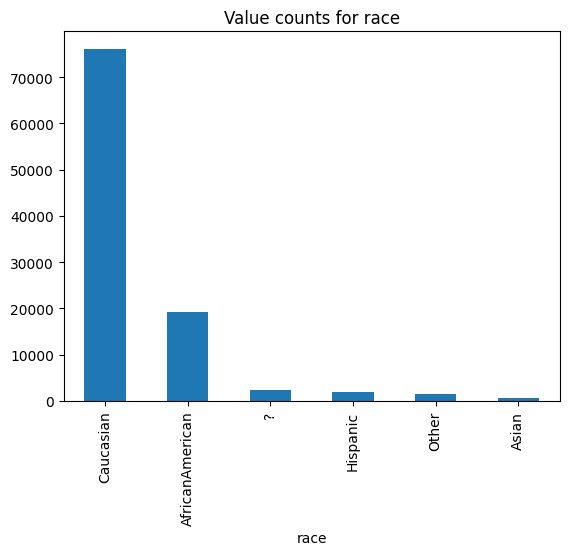

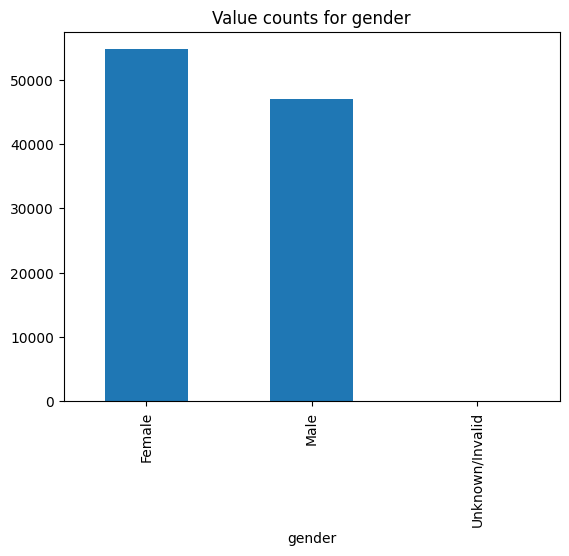

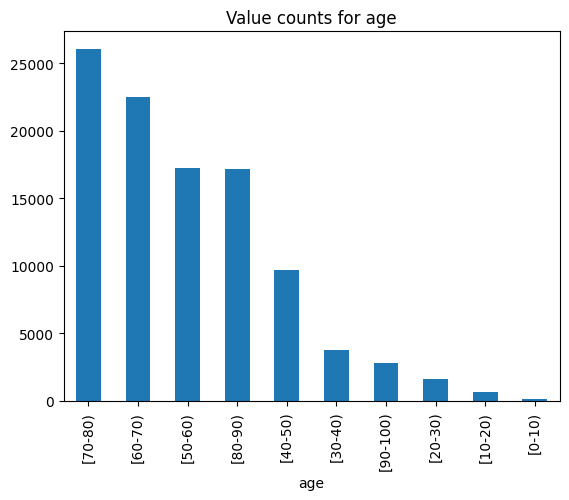

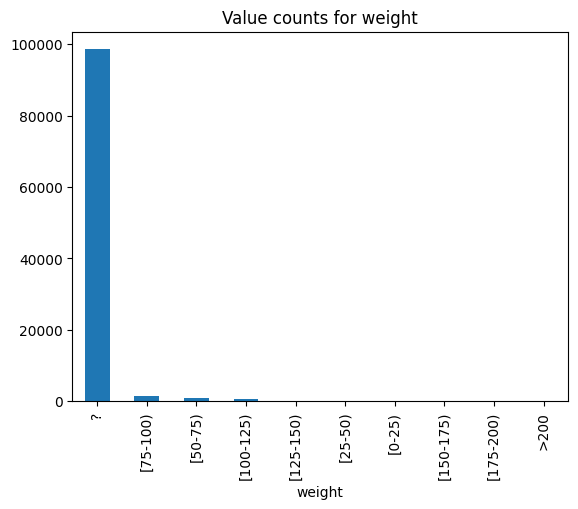

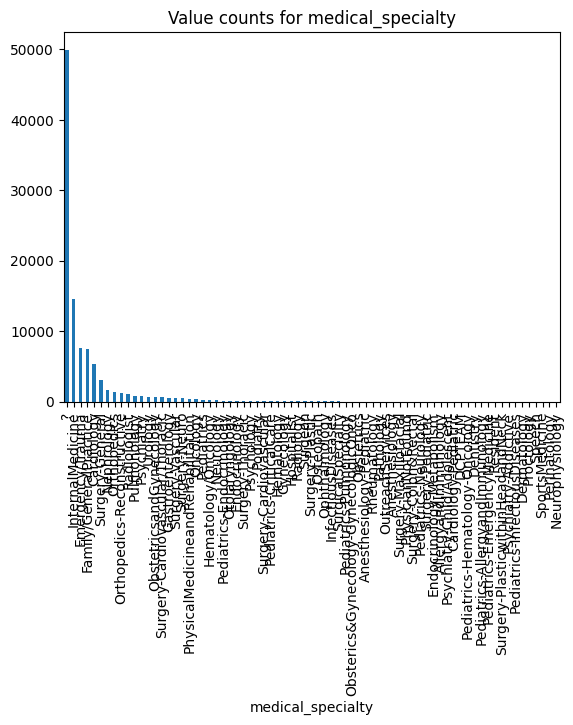

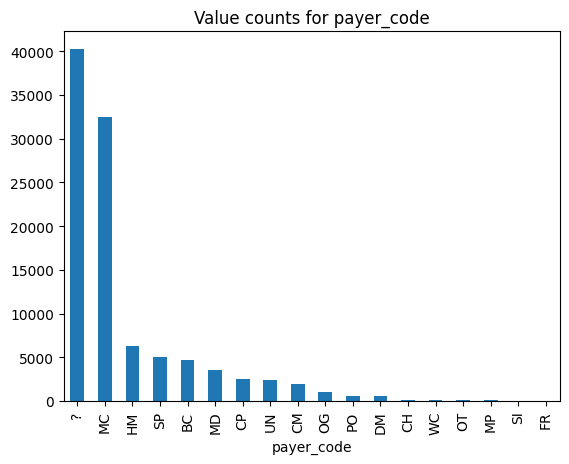

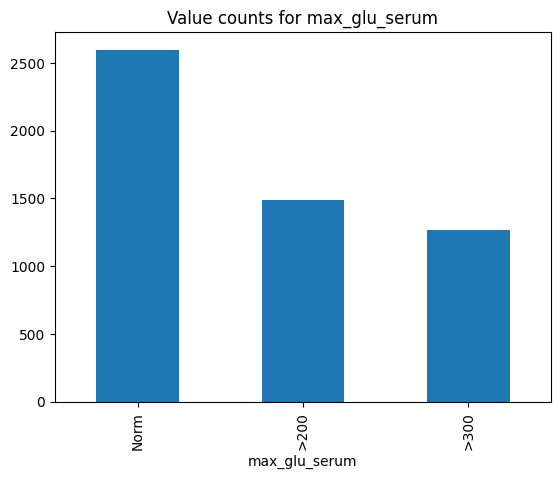

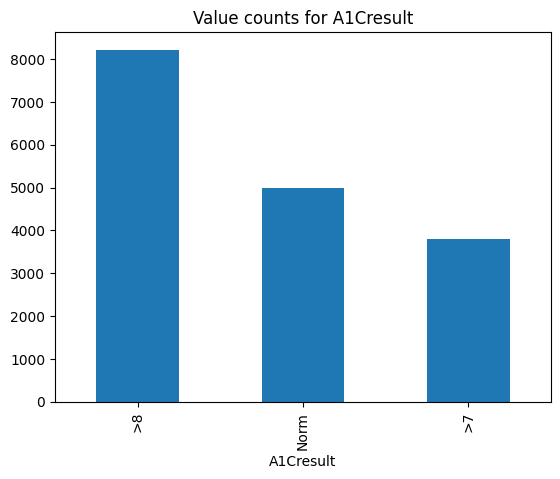

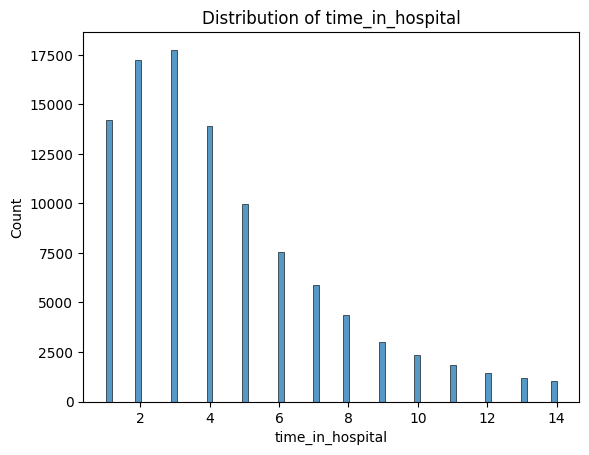

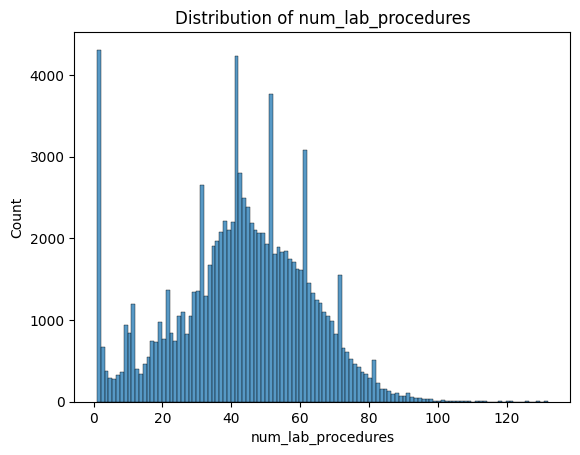

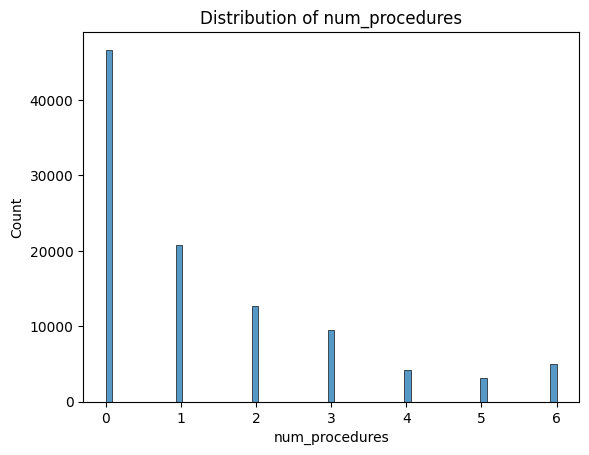

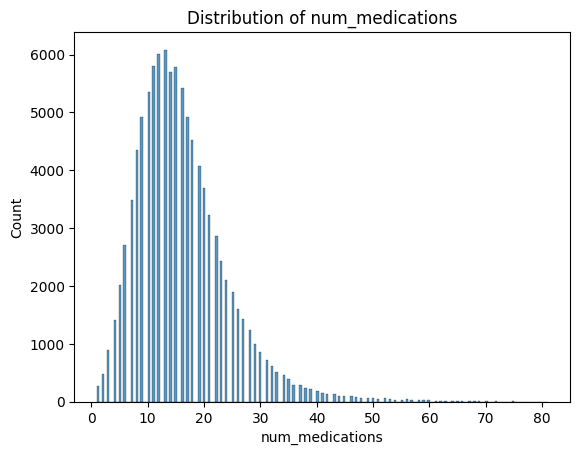

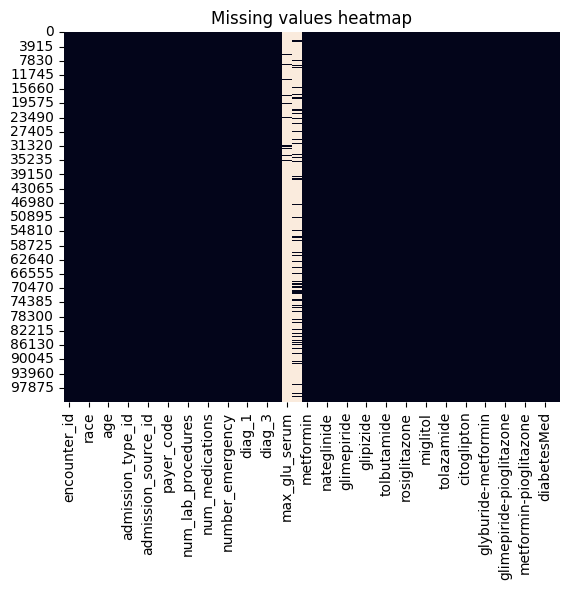

In [6]:
# initial exploration of the dataset
print("Variables w/ datatypes: \n\n", df.dtypes)

print("\n\n\n\nSummary statistics:\n\n", df.describe())

print("\n\n\n\nAre there duplicate entries for unique identifier: \n")

print("\nEncounter ID:", df.duplicated(subset='encounter_id').unique())

categorical_cols = ['race', 'gender', 'age', 'weight', 'medical_specialty', 'payer_code', 'max_glu_serum', 'A1Cresult']
for col in categorical_cols:
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Value counts for {col}')
    plt.show()

numerical_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications']
for col in numerical_cols:
    sns.histplot(df[col].dropna())
    plt.title(f'Distribution of {col}')
    plt.show()

sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing values heatmap')
plt.show()


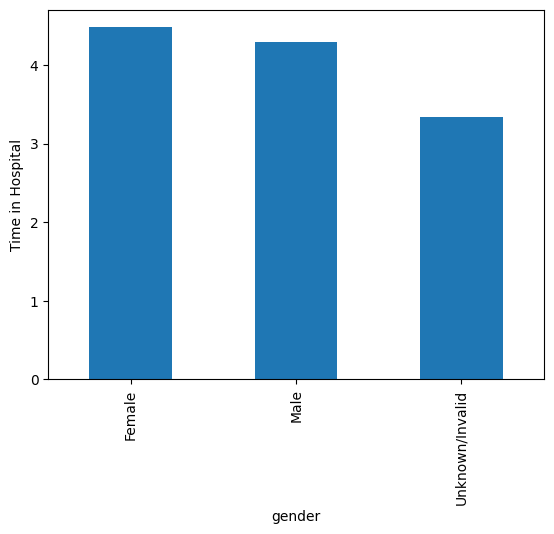

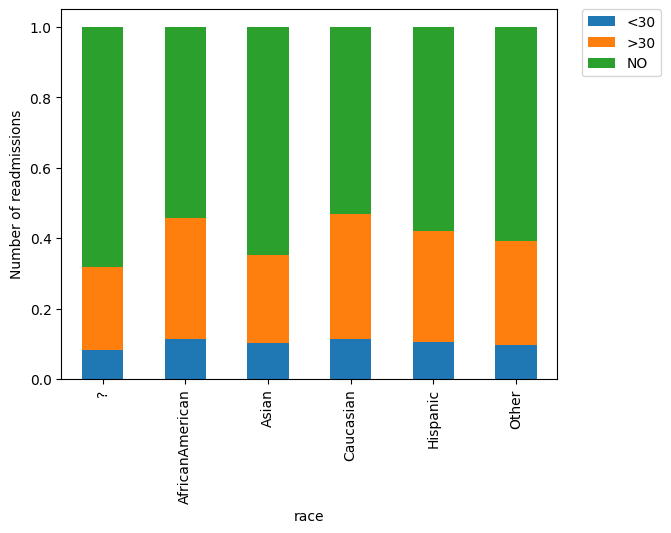

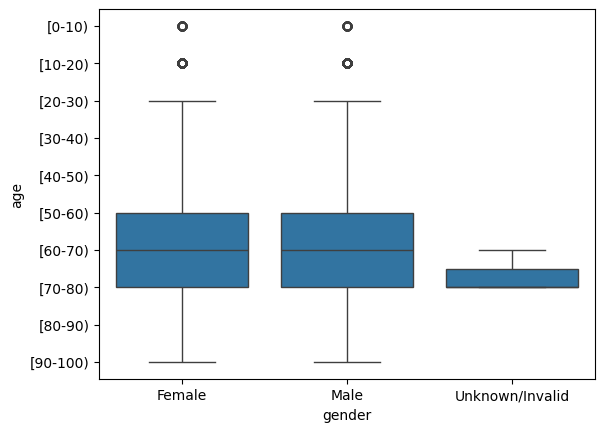

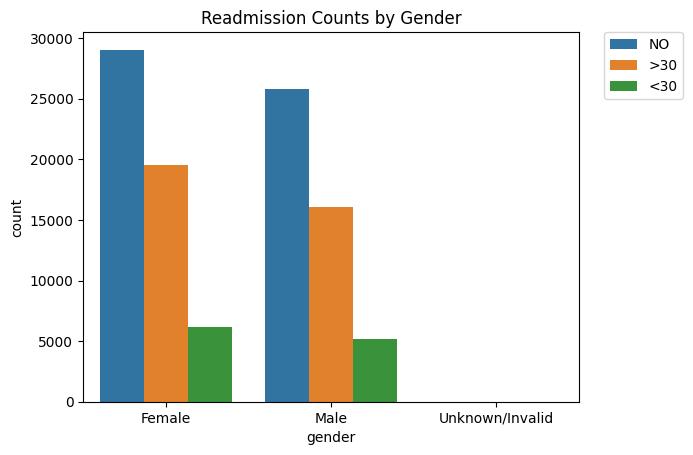

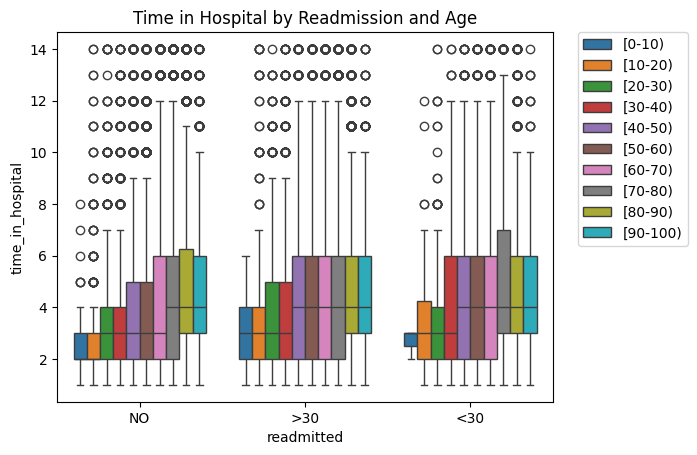

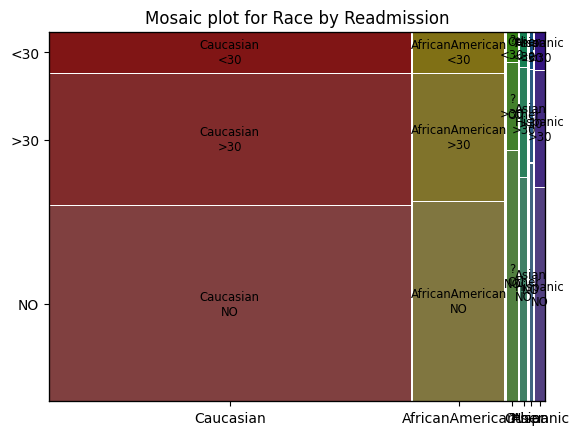

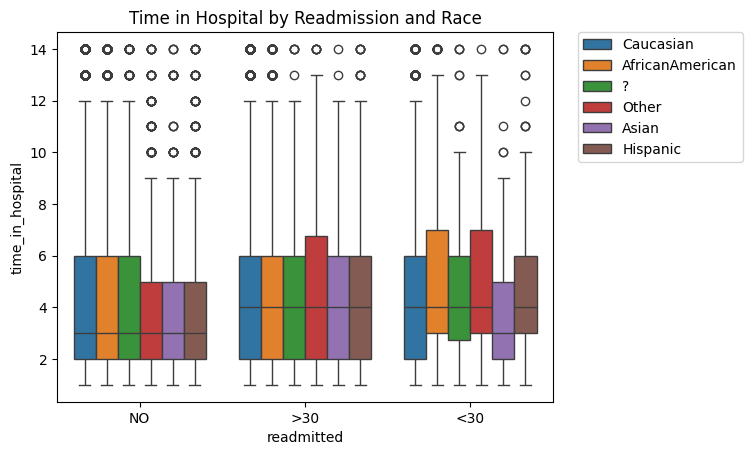

In [7]:
# Research Question Origin/Alters/Genderabhängige Unterschiede

df.groupby('gender')['time_in_hospital'].mean().plot(kind='bar')
plt.ylabel('Time in Hospital')
plt.show()

df.groupby('race')['readmitted'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
plt.ylabel('Number of readmissions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

sns.boxplot(x='gender', y='age', data=df)
plt.show()


# Example: Count plot of readmissions by gender
sns.countplot(x='gender', hue='readmitted', data=df)
plt.title('Readmission Counts by Gender')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

sns.boxplot(x='readmitted', y='time_in_hospital', hue='age', data=df)
plt.title('Time in Hospital by Readmission and Age')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

# Example: Mosaic plot (requires statsmodels)

mosaic(df, ['race', 'readmitted'])
plt.title('Mosaic plot for Race by Readmission')
plt.show()

# Example: Boxplot comparing time in hospital by readmission and race
sns.boxplot(x='readmitted', y='time_in_hospital', hue='race', data=df)
plt.title('Time in Hospital by Readmission and Race')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()






In [8]:
import pandas as pd
import plotly.graph_objects as go

# --- columns (rename to yours) ---
A = "admission_source_id"
B = "discharge_disposition_id"
C = "readmitted"              # your 3rd target
pct = 0.01                    # 1% threshold (per column)
ELSE = "Other"

def bucket_small(df, col, pct=0.01, else_label="Other"):
    s = df[col].astype(str).fillna("Unknown")
    vc = s.value_counts()
    total = len(s)
    small_vals = vc[vc / total < pct].index
    return s.where(~s.isin(small_vals), else_label)

# 1) Collapse rare categories per column
df2 = df.copy()
for col in [A, B, C]:
    df2[col] = bucket_small(df2, col, pct=pct, else_label=ELSE)

# 2) Aggregate flows for A→B and B→C
ab = (df2[[A, B]].groupby([A, B]).size()
      .reset_index(name="value"))
bc = (df2[[B, C]].groupby([B, C]).size()
      .reset_index(name="value"))

# 3) Build node lists (keep layers distinct to avoid loops)
A_vals = sorted(ab[A].unique().tolist())
B_vals = sorted(pd.Index(ab[B]).union(bc[B]).unique().tolist())
C_vals = sorted(bc[C].unique().tolist())

labels_pretty = A_vals + B_vals + C_vals

# index offsets
a_off = 0
b_off = len(A_vals)
c_off = b_off + len(B_vals)
a_idx = {v: a_off + i for i, v in enumerate(A_vals)}
b_idx = {v: b_off + i for i, v in enumerate(B_vals)}
c_idx = {v: c_off + i for i, v in enumerate(C_vals)}

# links
src =  ab[A].map(a_idx).tolist() +  bc[B].map(b_idx).tolist()
tgt =  ab[B].map(b_idx).tolist() +  bc[C].map(c_idx).tolist()
val =  ab["value"].tolist()      +  bc["value"].tolist()

# pin three vertical columns
xpos = [0]*len(A_vals) + [0.5]*len(B_vals) + [1]*len(C_vals)

fig = go.Figure(go.Sankey(
    node=dict(label=labels_pretty, pad=15, thickness=14, x=xpos, y=None),
    link=dict(source=src, target=tgt, value=val)
))
fig.update_layout(title="Admissions → Discharge → Outcome (rare <1% grouped as Other)")
fig.show()


ModuleNotFoundError: No module named 'plotly'

## Within each primary diagnosis group, what are the top independent predictors of a readmission?

### Data preperation


In [ ]:
#print(df["diag_1"].unique())
ICD9_CHAPTERS = [
    (1,   139,  1,  "Infectious and parasitic diseases"),
    (140, 239,  2,  "Neoplasms"),
    (240, 279,  3,  "Endocrine, nutritional & metabolic diseases; immunity disorders"),
    (280, 289,  4,  "Diseases of the blood & blood-forming organs"),
    (290, 319,  5,  "Mental disorders"),
    (320, 389,  6,  "Diseases of the nervous system & sense organs"),
    (390, 459,  7,  "Diseases of the circulatory system"),
    (460, 519,  8,  "Diseases of the respiratory system"),
    (520, 579,  9,  "Diseases of the digestive system"),
    (580, 629, 10,  "Diseases of the genitourinary system"),
    (630, 679, 11,  "Complications of pregnancy, childbirth & the puerperium"),
    (680, 709, 12,  "Diseases of the skin & subcutaneous tissue"),
    (710, 739, 13,  "Diseases of the musculoskeletal system & connective tissue"),
    (740, 759, 14,  "Congenital anomalies"),
    (760, 779, 15,  "Certain conditions originating in the perinatal period"),
    (780, 799, 16,  "Symptoms, signs & ill-defined conditions"),
    (800, 999, 17,  "Injury & poisoning"),
]

diags = ["diag_1", "diag_2", "diag_3"]

edges  = [ICD9_CHAPTERS[0][0]] + [hi for (_, hi, _, _) in ICD9_CHAPTERS]  # [1, 139, 239, ..., 999]
labels = [grp for (_, _, grp, _) in ICD9_CHAPTERS]
for diag in diags:
    codes = pd.to_numeric(df[diag], errors="coerce")
    codes = np.floor(codes)
    df[diag+"_chapter"] = pd.cut(
        codes,
        bins=edges,
        labels=labels,
        include_lowest=True,
        right=True,           # intervals are (prev_edge, edge], e.g., (139,239]
        ordered=True
    )

    chapter_name_map = {grp: name for (_, _, grp, name) in ICD9_CHAPTERS}
    df[diag+"_chapter_name"] = df[diag+"_chapter"].map(chapter_name_map)

df.to_csv("diabetic_data_with_chapters.csv", index=False)


### Exploration

In [ ]:
import pandas as pd
import altair as alt

CATEGORY_COL = "diag_1_chapter"   # your categorical x (e.g., ICD-9 chapter 1..17)
VALUE_COL    = "readmitted" # the single numeric variable to bucket
# ------------------------------------------
chapter_order = list(range(1, 18))

# 1) Build buckets: 1 (<30), 2 (>=30), 3 (none)
map_dict = {"<30": 1, ">30": 2, "NO": 3}
df["_bucket"] = df[VALUE_COL].map(map_dict)


agg = (df.groupby([CATEGORY_COL, "_bucket"])
         .size()
         .reset_index(name="count")
         .rename(columns={CATEGORY_COL: "category", "_bucket": "bucket"}))

agg = (df.groupby([CATEGORY_COL, "_bucket"])
         .size()
         .reset_index(name="count")
         .rename(columns={CATEGORY_COL: "category", "_bucket": "bucket"}))


cats = sorted(agg["category"].dropna().unique().tolist())
all_idx = pd.MultiIndex.from_product([cats, [1,2,3]], names=["category","bucket"])
agg = (agg.set_index(["category","bucket"])
          .reindex(all_idx, fill_value=0)
          .reset_index())

agg["category"] = pd.Categorical(agg["category"], categories=cats, ordered=True)
agg["bucket"]   = pd.Categorical(agg["bucket"],   categories=[1,2,3], ordered=True)

chart = (
    alt.Chart(agg, title="Counts by ICD-9 Category and Readmission")
      .transform_calculate(
          bucket_label="datum.bucket == 1 ? '>30' : datum.bucket == 2 ? '<30' : 'NO'"
      )
      .mark_bar()
      .encode(
          x=alt.X("category:N", title="Category"),
          xOffset=alt.XOffset("bucket:N", sort=[1,2,3]),
          y=alt.Y("count:Q", title="Count"),
          color=alt.Color("bucket_label:N", title="Readmission", sort=[">30", "<30", "NO"]),
          tooltip=["category:N", "bucket_label:N", "count:Q"]
      )
      .properties(width=25*len(chapter_order), height=320)

)


icd9_ranges = {
    1:  "001–139  Infectious & parasitic diseases",
    2:  "140–239  Neoplasms",
    3:  "240–279  Endocrine/metabolic & immunity",
    4:  "280–289  Blood & blood-forming organs",
    5:  "290–319  Mental disorders",
    6:  "320–389  Nervous system & sense organs",
    7:  "390–459  Circulatory system",
    8:  "460–519  Respiratory system",
    9:  "520–579  Digestive system",
    10: "580–629  Genitourinary system",
    11: "630–679  Pregnancy/childbirth/puerperium",
    12: "680–709  Skin & subcutaneous tissue",
    13: "710–739  Musculoskeletal & connective tissue",
    14: "740–759  Congenital anomalies",
    15: "760–779  Perinatal conditions",
    16: "780–799  Symptoms/signs/ill-defined",
    17: "800–999  Injury & poisoning",
}

legend_df = pd.DataFrame({
    "chapter": chapter_order,
    "label": [f"{c} — {icd9_ranges[c]}" for c in chapter_order]
})

# A neat text panel; you can tweak width to fit your layout
side_labels = (
    alt.Chart(legend_df)
      .mark_text(align="left", baseline="top")
      .encode(
        x=alt.value(0),
          y=alt.Y("chapter:O", sort=chapter_order, axis=None),  # one line per chapter
          text="label:N"
      )
      .properties(width=300, height=320, title="ICD-9 Chapter Reference")
)
# --- COMBINE: your chart + the side reference (colors unchanged) ---
final_chart = alt.hconcat(chart, side_labels).resolve_legend(color="independent")
final_chart



C:\Users\rauchegger\AppData\Local\Temp\ipykernel_23632\2753225880.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\rauchegger\AppData\Local\Temp\ipykernel_23632\2753225880.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



alt.HConcatChart(...)

In [ ]:
sns.boxplot(x='diag_1_chapter', y='time_in_hospital', hue='readmitted', data=df)
plt.title('Time in Hospital by Diagnosis and Readmission')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
sns.boxplot(x='diag_2_chapter', y='time_in_hospital', hue='readmitted', data=df)
plt.title('Time in Hospital by Diagnosis and Readmission')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
sns.boxplot(x='diag_3_chapter', y='time_in_hospital', hue='readmitted', data=df)
plt.title('Time in Hospital by Diagnosis and Readmission')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

NameError: name 'sns' is not defined

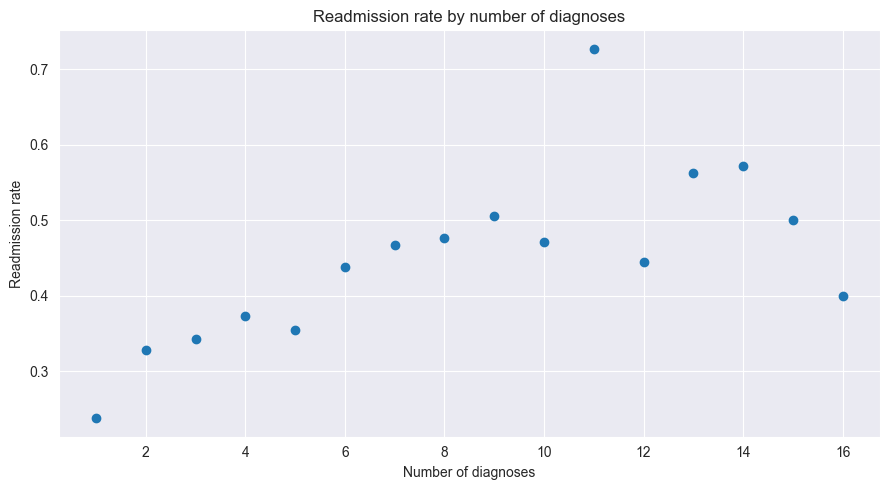

In [ ]:
y = (df["readmitted"].astype(str).str.strip().str.lower() != "no").astype(int)
x = df["number_diagnoses"].astype(int)

# Aggregate rate by each count
rate_by_count = pd.DataFrame({
    "number_diagnoses": x,
    "readmitted": y
}).groupby("number_diagnoses", as_index=False)["readmitted"].mean()

# Plot (bars)
plt.figure(figsize=(9,5))
plt.scatter(rate_by_count["number_diagnoses"], rate_by_count["readmitted"])
plt.xlabel("Number of diagnoses")
plt.ylabel("Readmission rate")
plt.title("Readmission rate by number of diagnoses")
plt.tight_layout()
plt.savefig("readmit_rate_by_num_diagnoses_bar.png", dpi=200)
plt.show()

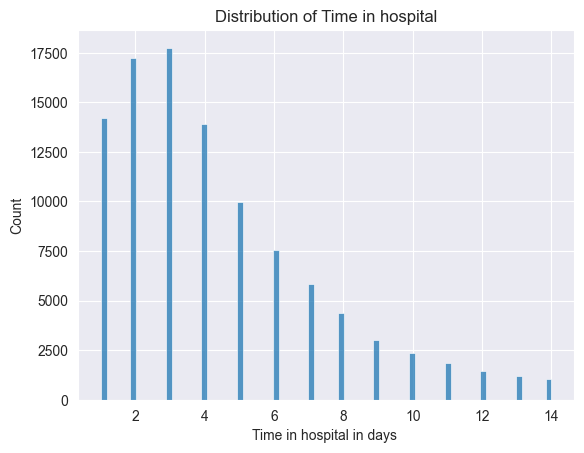

In [ ]:
numerical_cols = ['time_in_hospital']
for col in numerical_cols:
    sns.histplot(df[col].dropna())
    plt.title(f'Distribution of Time in hospital')
    plt.xlabel("Time in hospital in days ")
    plt.show()

In [22]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

corr_matrix = df[numerical_cols].drop(columns=['encounter_id', 'admission_source_id', 'admission_type_id', 'discharge_disposition_id', 'patient_nbr']).corr()

corr_df = corr_matrix.reset_index().melt(id_vars='index')
corr_df.columns = ['var1', 'var2', 'correlation']

heatmap = alt.Chart(corr_df).mark_rect().encode(
    x=alt.X('var1:N', title=''),
    y=alt.Y('var2:N', title=''),
    color=alt.Color('correlation:Q', 
                    scale=alt.Scale(scheme='redblue', reverse=True, domain=[-1, 1]),
                    title='Correlation'),
    tooltip=['var1:N', 'var2:N', alt.Tooltip('correlation:Q', format='.3f')]
).properties(
    width=600,
    height=600,
    title='Correlation Matrix of Numerical Variables'
)

text = alt.Chart(corr_df).mark_text(baseline='middle').encode(
    x=alt.X('var1:N', title=''),
    y=alt.Y('var2:N', title=''),
    text=alt.Text('correlation:Q', format='.2f'),
    color=alt.condition(
        alt.datum.correlation > 0.5,
        alt.value('white'),
        alt.value('black')
    )
)

correlation_chart = (heatmap + text).configure_axis(
    labelFontSize=10,
    labelAngle=-45
)

correlation_chart


alt.LayerChart(...)

In [24]:
# Check medication-related columns
medication_cols = [col for col in df.columns if 'insulin' in col.lower() or 'diabetesMed' in col or 'metformin' in col.lower() or 'glipizide' in col.lower() or 'glyburide' in col.lower()]
print("Medication columns found:")
print(medication_cols)
print("\n")

# Check unique values for a few medication columns
for col in medication_cols[:5]:
    print(f"\n{col}: {df[col].unique()}")

Medication columns found:
['metformin', 'glipizide', 'glyburide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diabetesMed']



metformin: ['No' 'Steady' 'Up' 'Down']

glipizide: ['No' 'Steady' 'Up' 'Down']

glyburide: ['No' 'Steady' 'Up' 'Down']

insulin: ['No' 'Up' 'Steady' 'Down']

glyburide-metformin: ['No' 'Steady' 'Down' 'Up']


## Medication Analysis - Effect on Readmission Rate

In [ ]:
med_columns = [col for col in df.columns if col not in ['race', 'gender', 'age', 'weight', 
               'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
               'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures',
               'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency',
               'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
               'max_glu_serum', 'A1Cresult', 'readmitted', 'encounter_id', 'patient_nbr',
               'change', 'diabetesMed'] and 
               not col.endswith('_chapter') and not col.endswith('_chapter_name') and 
               not col.startswith('_')]

print(f"Found {len(med_columns)} medication columns")
print("Sample medications:", med_columns[:10])

df['readmitted_binary'] = (df['readmitted'] != 'NO').astype(int)

medication_data = []

for med in med_columns:
    med_values = df[med].unique()
    
    for status in med_values:
        if pd.notna(status):  # Skip NaN values
            subset = df[df[med] == status]
            if len(subset) > 50:  # Only include if we have enough samples
                readmit_rate = subset['readmitted_binary'].mean()
                count = len(subset)
                medication_data.append({
                    'medication': med,
                    'status': status,
                    'readmission_rate': readmit_rate,
                    'count': count,
                    'medication_status': f"{med} ({status})"
                })

med_df = pd.DataFrame(medication_data)
print(f"\nCreated dataset with {len(med_df)} medication-status combinations")
med_df.head(10)

Found 23 medication columns
Sample medications: ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone']

Created dataset with 50 medication-status combinations


,medication,status,readmission_rate,count,medication_status
0,metformin,No,0.467815,81778,metformin (No)
1,metformin,Steady,0.433391,18346,metformin (Steady)
2,metformin,Up,0.407685,1067,metformin (Up)
3,metformin,Down,0.450435,575,metformin (Down)
4,repaglinide,No,0.459527,100227,repaglinide (No)
5,repaglinide,Up,0.481818,110,repaglinide (Up)
6,repaglinide,Steady,0.556358,1384,repaglinide (Steady)
7,nateglinide,No,0.460703,101063,nateglinide (No)
8,nateglinide,Steady,0.488024,668,nateglinide (Steady)
9,chlorpropamide,No,0.460887,101680,chlorpropamide (No)


In [73]:
med_comparison = []

for med in med_columns:
    # Any medication (Steady, Up, Down)
    any_med = df[df[med].isin(['Steady', 'Up'])]
    
    if len(any_med) >= 50:
        any_rate = any_med['readmitted_binary'].mean()
        med_comparison.append({
            'medication': med,
            'status': 'Prescribed',
            'readmission_rate': any_rate,
            'count': len(any_med)
        })
    else:
        continue

    # No medication
    no_med = df[df[med] == 'No']
    if len(no_med) >= 50:
        no_rate = no_med['readmitted_binary'].mean()
        med_comparison.append({
            'medication': med,
            'status': 'Not Prescribed',
            'readmission_rate': no_rate,
            'count': len(no_med)
        })
    
    

med_comp_df = pd.DataFrame(med_comparison)

med_diff = med_comp_df.pivot(index='medication', columns='status', values='readmission_rate').reset_index()

if 'Prescribed' in med_diff.columns and 'Not Prescribed' in med_diff.columns:
    med_diff['rate_difference'] = med_diff['Prescribed'] - med_diff['Not Prescribed']
    med_diff = med_diff.sort_values('rate_difference', ascending=False)
    
    #print("Top medications that INCREASE readmission when prescribed:")
    #print(med_diff.head(5)[['medication', 'rate_difference']])
    #print("\nTop medications that DECREASE readmission when prescribed:")
    #print(med_diff.tail(5)[['medication', 'rate_difference']])

prescribed_rates = med_comp_df[med_comp_df['status'] == 'Prescribed'].sort_values('readmission_rate', ascending=False)
med_order = prescribed_rates['medication'].tolist()

chart_comp = alt.Chart(med_comp_df).mark_bar().encode(
    x=alt.X('medication:N', title='Medication', sort=med_order),
    xOffset='status:N',
    y=alt.Y('readmission_rate:Q', title='Readmission Rate', scale=alt.Scale(domain=[0, 0.7])),
    color=alt.Color('status:N', title='Medication Status',
                    scale=alt.Scale(domain=['Not Prescribed', 'Prescribed'],
                                   range=["#8f8f8f", "#58c782"])),
    tooltip=[
        alt.Tooltip('medication:N', title='Medication'),
        alt.Tooltip('status:N', title='Status'),
        alt.Tooltip('readmission_rate:Q', title='Readmission Rate', format='.3f'),
        alt.Tooltip('count:Q', title='Number of Patients', format=',')
    ]
).properties(
    width=800,
    height=400,
    title='Readmission Rates: Not Prescribed vs Prescribed'
).configure_axis(
    labelAngle=-45,
    labelFontSize=14
).configure_legend(
    titleFontSize=14,
    labelFontSize=14
)

chart_comp

alt.Chart(...)

In [44]:
key_meds = ['insulin', 'metformin', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone']
key_med_data = med_df[med_df['medication'].isin(key_meds) & (med_df['count'] >= 50)].copy()

if len(key_med_data) > 0:
    chart_key = alt.Chart(key_med_data).mark_bar().encode(
        x=alt.X('status:N', title='Medication Status', 
                sort=['No', 'Steady', 'Up', 'Down']),
        y=alt.Y('readmission_rate:Q', title='Readmission Rate'),
        color=alt.Color('status:N', title='Status',
                        scale=alt.Scale(domain=['No', 'Steady', 'Up', 'Down'],
                                       range=['#95a5a6', '#3498db', '#e74c3c', '#f39c12'])),
        column=alt.Column('medication:N', title='Medication'),
        tooltip=[
            alt.Tooltip('medication:N', title='Medication'),
            alt.Tooltip('status:N', title='Status'),
            alt.Tooltip('readmission_rate:Q', title='Readmission Rate', format='.3f'),
            alt.Tooltip('count:Q', title='Number of Patients', format=',')
        ]
    ).properties(
        width=150,
        height=300,
        title='Readmission Rates by Key Diabetes Medications'
    ).configure_axis(
        labelFontSize=14,
        titleFontSize=12
    ).configure_header(
        labelFontSize=16,
        titleFontSize=18
    ).configure_title(
        fontSize=18
    ).configure_legend(
        labelFontSize=14,
        titleFontSize=16
    )
    
    chart_key.show()
else:
    print("No key medication data available with sufficient samples")

alt.Chart(...)

In [58]:
med_pivot = med_df[med_df['count'] >= 100].pivot( # only meds with enough samples
    index='medication', 
    columns='status', 
    values='readmission_rate'
).reset_index()

med_heatmap_data = med_pivot.melt(id_vars='medication', var_name='status', value_name='readmission_rate')
med_heatmap_data = med_heatmap_data.dropna()

heatmap = alt.Chart(med_heatmap_data).mark_rect().encode(
    x=alt.X('status:N', title='Medication Status', 
            sort=['No', 'Steady', 'Up', 'Down']),
    y=alt.Y('medication:N', title='Medication'),
    color=alt.Color('readmission_rate:Q', 
                    scale=alt.Scale(scheme='redyellowgreen', domain=[0.1, 0.6], reverse=True),
                    title='Readmission Rate'),
    tooltip=[
        alt.Tooltip('medication:N', title='Medication'),
        alt.Tooltip('status:N', title='Status'),
        alt.Tooltip('readmission_rate:Q', title='Readmission Rate', format='.3f')
    ]
).properties(
    width=400,
    height=600,
    title='Medication Status vs Readmission Rate Heatmap'
)

text = alt.Chart(med_heatmap_data).mark_text(baseline='middle').encode(
    x=alt.X('status:N', sort=['No', 'Steady', 'Up', 'Down']),
    y=alt.Y('medication:N'),
    text=alt.Text('readmission_rate:Q', format='.2f'),
    color=alt.condition(
        alt.datum.readmission_rate > 0.4,
        alt.value('white'),
        alt.value('black')
    )
)

heatmap + text

alt.LayerChart(...)

## Risk Factors for Patient Readmission (Non-Medication)

In [87]:
risk_factors_categorical = ['race', 'gender', 'age', 'weight', 'admission_type_id', 
                           'discharge_disposition_id', 'admission_source_id',
                           'max_glu_serum', 'A1Cresult', 'diag_1_chapter']

risk_factors_numerical = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                         'num_medications', 'number_outpatient', 'number_emergency',
                         'number_inpatient', 'number_diagnoses']

risk_data = []

for factor in risk_factors_categorical:
    if factor in df.columns:
        factor_groups = df.groupby(factor)['readmitted_binary'].agg(['mean', 'count']).reset_index()
        factor_groups = factor_groups[factor_groups['count'] >= 50]  # Minimum sample size
        
        for _, row in factor_groups.iterrows():
            risk_data.append({
                'factor': factor,
                'value': str(row[factor]),
                'readmission_rate': row['mean'],
                'count': row['count']
            })

risk_df = pd.DataFrame(risk_data)
print(f"Created risk factor dataset with {len(risk_df)} factor-value combinations")
risk_df.head(10)

Created risk factor dataset with 63 factor-value combinations


,factor,value,readmission_rate,count
0,race,?,0.319402,2273.0
1,race,AfricanAmerican,0.457522,19210.0
2,race,Asian,0.352574,641.0
3,race,Caucasian,0.469336,76099.0
4,race,Hispanic,0.419244,2037.0
5,race,Other,0.392430,1506.0
6,gender,Female,0.469218,54708.0
7,gender,Male,0.451217,47055.0
8,age,[0-10),0.180124,161.0
9,age,[10-20),0.382055,691.0


In [89]:
demographic_factors = ['age', 'gender', 'race', 'weight']
demo_data = risk_df[risk_df['factor'].isin(demographic_factors)].copy()

weight_order = ['?', '[0-25)', '[25-50)', '[50-75)', '[75-100)', '[100-125)', '[125-150)', '[150-175)', '[175-200)']
age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']

def get_sort_key(row):
    if row['factor'] == 'weight' and row['value'] in weight_order:
        return weight_order.index(row['value'])
    elif row['factor'] == 'age' and row['value'] in age_order:
        return age_order.index(row['value'])
    else:
        return row['readmission_rate']

demo_data['sort_key'] = demo_data.apply(get_sort_key, axis=1)

chart_demo = alt.Chart(demo_data).mark_bar().encode(
    x=alt.X('value:N', title='', sort=alt.EncodingSortField(field='sort_key', order='ascending')),
    y=alt.Y('readmission_rate:Q', title='Readmission Rate'),
    color=alt.Color('readmission_rate:Q',
                    scale=alt.Scale(scheme='redyellowgreen', domain=[0, 0.6], reverse=True),
                    title='Rate'),
    column=alt.Column('factor:N', title=None),
    tooltip=[
        alt.Tooltip('factor:N', title='Factor'),
        alt.Tooltip('value:N', title='Value'),
        alt.Tooltip('readmission_rate:Q', title='Readmission Rate', format='.3f'),
        alt.Tooltip('count:Q', title='Number of Patients', format=',')
    ]
).properties(
    width=150,
    height=300,
    title='Readmission Rates by Demographics'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14,
    labelAngle=-45
).configure_header(
    labelFontSize=14,
    titleFontSize=16
).configure_title(
    fontSize=16
).resolve_scale(
    x='independent'
)

chart_demo

alt.Chart(...)

In [ ]:
utilization_factors = ['number_inpatient', 'number_outpatient', 'number_emergency']

util_data = []
for factor in utilization_factors:
    if factor in df.columns:
        # Group by exact counts (0, 1, 2, 3+)
        df[f'{factor}_group'] = df[factor].apply(lambda x: '0' if x == 0 else '1' if x == 1 else '2' if x == 2 else '3+')
        
        groups = df.groupby(f'{factor}_group')['readmitted_binary'].agg(['mean', 'count']).reset_index()
        groups = groups[groups['count'] >= 50]
        
        for _, row in groups.iterrows():
            util_data.append({
                'factor': factor.replace('number_', '').capitalize(),
                'visits': row[f'{factor}_group'],
                'readmission_rate': row['mean'],
                'count': row['count']
            })

util_df = pd.DataFrame(util_data)

chart_util = alt.Chart(util_df).mark_line(point=True).encode(
    x=alt.X('visits:N', title='Number of Prior Visits', sort=['0', '1', '2', '3+']),
    y=alt.Y('readmission_rate:Q', title='Readmission Rate'),
    color=alt.Color('factor:N', title='Visit Type'),
    strokeWidth=alt.value(3),
    tooltip=[
        alt.Tooltip('factor:N', title='Visit Type'),
        alt.Tooltip('visits:N', title='Number of Visits'),
        alt.Tooltip('readmission_rate:Q', title='Readmission Rate', format='.3f'),
        alt.Tooltip('count:Q', title='Number of Patients', format=',')
    ]
).properties(
    width=600,
    height=400,
    title='Prior Healthcare Utilization Impact on Readmission'
).configure_axis(
    labelFontSize=14,
    titleFontSize=16
).configure_title(
    fontSize=18
).configure_legend(
    labelFontSize=14,
    titleFontSize=16
)

chart_util

alt.Chart(...)

In [102]:
# Visualization 5: Hospital admission and discharge factors
admission_factors = risk_df[risk_df['factor'].isin(['admission_type_id', 'admission_source_id', 'discharge_disposition_id'])]

# Sort by readmission rate within each factor
chart_admission = alt.Chart(admission_factors).mark_bar().encode(
    x=alt.X('readmission_rate:Q', title='Readmission Rate'),
    y=alt.Y('value:N', title='', sort='-x'),
    color=alt.Color('readmission_rate:Q',
                    scale=alt.Scale(scheme='redyellowgreen', domain=[0, 1], reverse=True),
                    title='Rate'),
    row=alt.Row('factor:N', title='', header=alt.Header(labelAngle=0, labelAlign='left')),
    tooltip=[
        alt.Tooltip('factor:N', title='Factor'),
        alt.Tooltip('value:N', title='Value'),
        alt.Tooltip('readmission_rate:Q', title='Readmission Rate', format='.3f'),
        alt.Tooltip('count:Q', title='Number of Patients', format=',')
    ]
).properties(
    width=600,
    height=180,
    title='Admission and Discharge Factors Impact on Readmission'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16
).resolve_scale(
    y='independent'
)

chart_admission

alt.Chart(...)

In [121]:
factor_medians = risk_df.groupby('factor')['readmission_rate'].median().sort_values(ascending=False)
factor_order = factor_medians.index.tolist()

# Calculate overall average readmission rate
overall_avg_rate = df['readmitted_binary'].mean()
print(f"Overall average readmission rate: {overall_avg_rate:.3f} ({overall_avg_rate*100:.1f}%)")

boxplot = alt.Chart(risk_df).mark_boxplot(size=30).encode(
    y=alt.Y('factor:N', title='Risk Factor', sort=factor_order),
    x=alt.X('readmission_rate:Q', title='Readmission Rate', scale=alt.Scale(domain=[0, 1])),
    color=alt.Color('factor:N', legend=None),
    tooltip=[
        alt.Tooltip('factor:N', title='Risk Factor')
    ]
)

avg_line = alt.Chart(pd.DataFrame({'avg': [overall_avg_rate]})).mark_rule(
    color='red',
    strokeWidth=2,
    strokeDash=[6, 6]
).encode(
    x='avg:Q'
)

avg_text = alt.Chart(pd.DataFrame({
    'avg': [overall_avg_rate],
    'label': [f'Overall Avg: {overall_avg_rate:.3f}']
})).mark_text(
    align='right',
    dx=-5,
    dy=-5,
    color='red',
    fontSize=12,
    fontWeight='bold'
).encode(
    x='avg:Q',
    y=alt.value(10),
    text='label:N'
)

chart_summary = (boxplot + avg_line + avg_text).properties(
    width=700,
    height=400,
    title='Risk Factor Comparison: Distribution of Readmission Rates Across Categories'
).configure_axis(
    labelFontSize=14,
    titleFontSize=16
).configure_title(
    fontSize=16
)

chart_summary

Overall average readmission rate: 0.461 (46.1%)


alt.LayerChart(...)

In [106]:
clinical_factors = risk_df[risk_df['factor'].isin(['max_glu_serum', 'A1Cresult', 'diag_1_chapter'])]

chart_clinical = alt.Chart(clinical_factors).mark_bar().encode(
    x=alt.X('value:N', title='', sort='-y'),
    y=alt.Y('readmission_rate:Q', title='Readmission Rate', scale=alt.Scale(domain=[0, 0.8])),
    color=alt.Color('readmission_rate:Q',
                    scale=alt.Scale(scheme='redyellowgreen', domain=[0, 0.6], reverse=True),
                    title='Rate'),
    column=alt.Column('factor:N', title=None),
    tooltip=[
        alt.Tooltip('factor:N', title='Factor'),
        alt.Tooltip('value:N', title='Value'),
        alt.Tooltip('readmission_rate:Q', title='Readmission Rate', format='.3f'),
        alt.Tooltip('count:Q', title='Number of Patients', format=',')
    ]
).properties(
    width=200,
    height=300,
    title='Clinical Indicators and Primary Diagnosis Impact'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14,
    labelAngle=-45
).configure_header(
    labelFontSize=14,
    titleFontSize=16
).configure_title(
    fontSize=16
).resolve_scale(
    x='independent'
)

chart_clinical

alt.Chart(...)